In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [27]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.inspection import inspect

In [29]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model

# Declare a Base using `automap_base()` and Use the Base class to reflect the database tables

Base=automap_base()
Base.prepare(engine, reflect=True)


In [31]:
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [32]:
# View all of the classes that automap found


In [33]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [34]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [35]:
# Find the most recent date in the data set.
Recent_date_set = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
Recent_date = dt.date.fromisoformat(Recent_date_set)
Recent_date


datetime.date(2017, 8, 23)

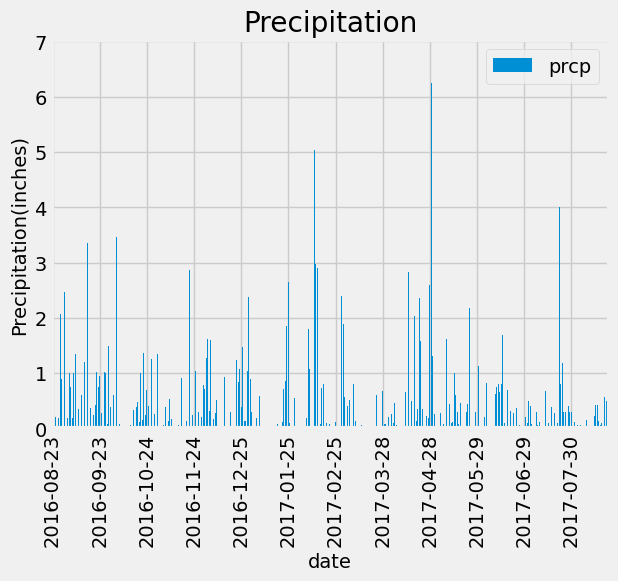

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

Last_TwelveMonths_date = dt.date(Recent_date.year-1,Recent_date.month,Recent_date.day)
Last_TwelveMonths_date

# Perform a query to retrieve the data and precipitation scores
precipitation_score = session.query(Measurement.date,func.max(Measurement.prcp)).\
    filter(Measurement.date >= func.strftime("%Y-%m-%d",Last_TwelveMonths_date)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_score, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df

# Sort the dataframe by date

df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar()
#plt.tight_layout()
plt.xticks(rotation = 90)
plt.title("Precipitation")
plt.ylabel("Precipitation(inches)")
plt.locator_params(axis='x',nbins=12)
plt.show()

In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data

precipitation_query = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= func.strftime("%Y-%m-%d",Last_TwelveMonths_date)).\
    order_by(Measurement.date).all()

precipitaion_df = pd.DataFrame(precipitation_query, columns=['date', 'prcp'])
precipitaion_df.set_index('date', inplace=True)
precipitaion_df
max_precipitation = precipitaion_df.groupby(["date"]).max()["prcp"] 
min_precipitation = precipitaion_df.groupby(["date"]).min()["prcp"] 
sum_precipitation = precipitaion_df.groupby(["date"]).sum()["prcp"] 
precipitation_count = precipitaion_df.groupby(["date"]).count()["prcp"] 

precipitation_dict = {"Max": max_precipitation
                 ,"Min":min_precipitation
                 ,"Sum":sum_precipitation
                 ,"Count":precipitation_count 
                }

precipitation_summary_df = pd.DataFrame(precipitation_dict)
precipitation_summary_df

,Max,Min,Sum,Count
date,,,,
2016-08-23,1.79,0.00,2.71,6
2016-08-24,2.28,0.08,9.33,6
2016-08-25,0.21,0.00,0.54,7
2016-08-26,0.04,0.00,0.10,6
2016-08-27,0.18,0.00,0.32,5
...,...,...,...,...
2017-08-19,0.09,0.00,0.09,3
2017-08-20,0.01,0.00,0.01,2
2017-08-21,0.56,0.00,0.58,3


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()

total_stations

9

In [45]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations_query = session.query(
        Measurement.station,
        func.count(Measurement.station)
    ).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())

most_active_stations = most_active_stations_query.all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations_query.first()[0]
most_active_station_id

temp_summary = session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    ).\
    filter(Measurement.station == most_active_station_id).all()

temp_summary

[(54.0, 85.0, 71.66378066378067)]

<Axes: >

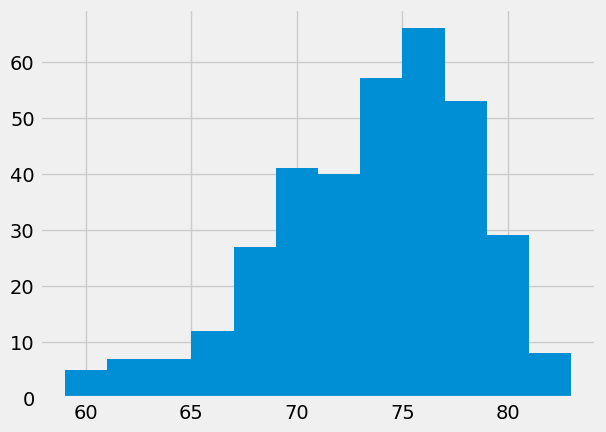

In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

lastoneyear_temperatue_observation = session.query(Measurement.date,Measurement.tobs).\
    filter(
        Measurement.date >= func.strftime("%Y-%m-%d", Last_TwelveMonths_date), 
        Measurement.station == most_active_station_id
    ).\
    order_by(Measurement.date).all()

df = pd.DataFrame(lastoneyear_temperatue_observation, columns=['date', 'tobs'])

hist = df["tobs"].hist(bins=12)

hist

# Close Session

In [16]:
# Close Session
session.close()